In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
import math
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
from workers import workers
import pickle

## Base Model
$e_n^{target} = (r_n - r_n^{est})$

$r_{n+1}^{est} = Ar_n^{est} + Be_n^{target}$

In [19]:
num_trials = 640
def base_model_sudden(num_trials, A, B):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90
    rotation_est = 0
    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors

def base_model_gradual(num_trials, A, B):
#    A = np.exp(A)/(1 + np.exp(A))
#    B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors

In [20]:
def base_model_transfer(num_trials, A, B, learned_rotation):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90 - learned_rotation
    rotation_est = 0
    for trial in range(num_trials):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        rotation_est = A*rotation_est + B*errors[trial]
        #print (rotation_est)
    return errors


# Data
## Curvatures

In [2]:
def calc_angle(current_point, next_point, final_point):
    #vec1 = next_point - current_point
    vec1 = np.subtract(next_point, current_point)
#    vec2 = final_point - current_point
    vec2 = np.subtract(final_point, current_point)
    vec1 = vec1.astype('float64')
    vec2 = vec2.astype('float64')
    cos_theta = np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))
    theta = np.degrees(np.arccos(cos_theta))
    return theta

def calc_curvature(data, block, trial, percentage_trajectory):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
    targetx, targety = trajx[-1], trajy[-1]
    partial_trajx, partial_trajy = get_partial_traj(data, block, trial, percentage_trajectory)
    #print (partial_trajx)
    #print (partial_trajy)
    angles = list([0])
    #for i in range(len(partial_trajx[:-1])):
        #print (trajx[i], trajy[i])
    #    angles.append(calc_angle(np.array([partial_trajx[i], partial_trajy[i]]), np.array([partial_trajx[i+1], partial_trajy[i+1]]), np.array([trajx[-1], trajy[-1]])))
    #return np.nanmedian(angles)
    return calc_angle(np.array([partial_trajx[0], partial_trajy[0]]), np.array([partial_trajx[-1], partial_trajy[-1]]), np.array([trajx[-1], trajy[-1]]))

def get_traj(data, block, trial):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    x_traj = traj['x'][0][trial][0]
    y_traj = traj['y'][0][trial][0]
    return x_traj, y_traj

def get_partial_traj(data, block, trial, percentage_trajectory):
    traj = get_traj(data, block, trial)
    #dist_cutoff = percentage_trajectory*np.sqrt(traj[0][-1]**2 + traj[0][-1]**2, dtype = float)
    #for i in range(len(traj[0])):
        #dist_from_start = np.sqrt(traj[0][i]**2 + traj[1][i]**2, dtype = float)
        #if dist_from_start > dist_cutoff:
        #    break
    i = int(len(traj[0])/2)
    partial_trajx = traj[0][:i]
    partial_trajy = traj[1][:i]
        
            
    return partial_trajx, partial_trajy



In [3]:
#def calc_curvature_wrapper(params):
#    return calc_curvature(params[0], params[1], params[2], params[3])
paramlist = list(itertools.product(range(1000, 1060), range(12), range(64), range(1, 2)))


In [4]:
from workers import workers


if __name__ == '__main__':
    pool = Pool()
    res = np.reshape(np.array(pool.map(workers.calc_curvature_wrapper, paramlist)), (60, 12, 64))

In [5]:
curvatures = res

In [352]:
curvatures = np.zeros((60, 12, 64))
for data in range(60):
    for block in range(12):
#        curvatures[data][blocl][trial] = calc_curvature(data+1000, block, range(64), 1)
        for trial in range(64):
            curvatures[data][block][trial] = calc_curvature(data+1000, block, trial, 0.5)
    if data%10 == 0:
        print (data)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


0


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':


10
20
30
40
50


In [25]:
def residuals_base_sudden(params, num_trials, data_errors):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_sudden(num_trials, params[0], params[1])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0:# or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 1000000
    return residual_error

def residuals_base_gradual(params, num_trials, data_errors):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_gradual(num_trials, params[0], params[1])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0:# or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 1000000
    return residual_error

In [29]:
def minimize_parallel(args):
    f,x,a,stepsize = args
    res = scipy.optimize.basinhopping(f, x, minimizer_kwargs=a, stepsize = stepsize)
    return res


In [30]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits(curvatures, num_trials, part_size, first):
    num_parts = int((num_trials-first)/part_size)
    fit_A = np.zeros((60, num_parts))
    fit_B = np.zeros((60, num_parts))
    fit_V = np.full((60, num_parts), np.inf)
    fit_success = np.zeros((60, num_parts))
    fit_num = 0
    #starting_points = np.array([[0.5, 0.6], [0.4, 0.7], [0.3, 0.8], [0.2, 0.9], [0.1, 0.99], [0.9, 0.2], [0.99, 0.1], [0.8, 0.3], [0.7, 0.4], [0.6, 0.5]])
    
    #A = np.log(params[0]/(1-params[0]))
    #B = np.log(params[1]/(1-params[1]))

#    starting_points = np.array([[np.log(0.999/(1 - 0.999)), np.log(0.002/(1 - 0.002))]])
    starting_points = np.array([[0.999, 0.002]])

    for curr_trial in range(first, num_trials, part_size):
        for participant in range(60):
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:
                #print (np.nan_to_num(np.ravel(curvatures[participant])[first:first+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[first:first+part_size])))
                #popt, pcov = curve_fit(base_model_sudden, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = minimize_parallel([residuals_base_sudden, [initial_point[0], initial_point[1]], {'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, 0.05])
#                    fits = scipy.optimize.basinhopping(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize=0.05)
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success   
                    print (fits.fun)
                else:
                    #popt, pcov = curve_fit(base_model_gradual, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'})
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success
                    print (fits.fun)

        fit_num = fit_num + 1
    return fit_A, fit_B, fit_V, fit_success
        

In [8]:
curvatures_smooth = gaussian_filter1d(curvatures, 2)
np.shape(curvatures_smooth)

(60, 12, 64)

In [32]:
fit_A, fit_B, fit_V, fit_success = run_fits(curvatures_smooth, 704, 640, 64)

64021.1532355539


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.


51997.750315784615


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Tejas\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


28738.816324553663
16167.869305696824
24003.44984081027
17546.47670346147
6562.357250493953
15347.36507770933
50012.09730448485
69704.79927552247
28728.117702552427
8726.287447113378
62759.27351840204
56423.02936485425
37086.466615104815
4122.174340457452
45776.11228702301
6747.387311715653
24226.085566257563
11411.227358626973
66864.23336316232
38670.09594550828
75264.21144803839
23612.40928018611
66856.68011661089
37506.19599787253
40681.65930560039
30271.39973461033
202983.8096176236
55295.73421339449
29756.525509349063
8217.157454242997
31842.956826177277
44052.137225188126
13874.113998630053
6656.069262793717
195456.1213856298
135178.5122427045
42286.80352792042
5593.90334944069
37759.01632656099
31046.23051700839
90021.50481730752
7039.654859324849
33807.589621359504
92825.24181933212
24972.361975559463
12772.395770651994
123799.11364742035
65715.72115133858
31565.90568598937
16584.584168734335
91546.36674888933
61395.01247634755
50935.896345473186
15151.618992561112
46086.725539

In [ ]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits_transfer(curvatures, num_trials, part_size, first):
    num_parts = int((num_trials-first)/part_size)
    fit_A = np.zeros((60, num_parts))
    fit_B = np.zeros((60, num_parts))
    fit_V = np.full((60, num_parts), np.inf)
    fit_success = np.zeros((60, num_parts))
    fit_num = 0
    #starting_points = np.array([[0.5, 0.6], [0.4, 0.7], [0.3, 0.8], [0.2, 0.9], [0.1, 0.99], [0.9, 0.2], [0.99, 0.1], [0.8, 0.3], [0.7, 0.4], [0.6, 0.5]])
    
    #A = np.log(params[0]/(1-params[0]))
    #B = np.log(params[1]/(1-params[1]))

#    starting_points = np.array([[np.log(0.999/(1 - 0.999)), np.log(0.002/(1 - 0.002))]])
    starting_points = np.array([[0.999, 0.002]])

    for curr_trial in range(first, num_trials, part_size):
        for participant in range(60):
            for initial_point in starting_points:
                fits = scipy.optimize.basinhopping(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize=0.05)
                if fits.fun < fit_V[participant][fit_num]:
                    fit_A[participant][fit_num] = fits.x[0]
                    fit_B[participant][fit_num] = fits.x[1]
                    fit_V[participant][fit_num] = fits.fun
                    #fit_success[participant][fit_num] = fits.success   
                print (fits.fun)
                #popt, pcov = curve_fit(base_model_gradual, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                #fits = scipy.optimize.minimize(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
#                fits = scipy.optimize.basinhopping(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'})#

#                if fits.fun < fit_V[participant][fit_num]:
#                    fit_A[participant][fit_num] = fits.x[0]
#                    fit_B[participant][fit_num] = fits.x[1]
#                    fit_V[participant][fit_num] = fits.fun
                    #fit_success[participant][fit_num] = fits.success
#                print (fits.fun)

        fit_num = fit_num + 1
    return fit_A, fit_B, fit_V, fit_success
        

In [ ]:
fit_transfer_A, fit_transfer_B, fit_transfer_V, fit_transfer_success = run_fits_transfer(curvatures_smooth, 768, 64, 704)

In [57]:
fit_Af = np.zeros((60, 1))
fit_Bf = np.zeros((60, 1))
fit_As = np.zeros((60, 1))
fit_Bs = np.zeros((60, 1))
fit_alpha = np.zeros((60, 1))
fit_V = np.zeros((60, 1))
f = open('fit_dual_lowerbound_alphaed.pickle', 'rb')
fits = pickle.load(f)
fit_Af[:, 0] = fits[:, 0] 
fit_Bf[:, 0] = fits[:, 1]
fit_As[:, 0] = fits[:, 2]
fit_Bs[:, 0] = fits[:, 3]
fit_alpha[:, 0] = fits[:, 4]
fit_V[:, 0] = fits[:, 5]

In [11]:
def plot_fits(fit_A, fit_B, x_label, y_label):
    x = np.array([np.nanmean(fit_A[0::4, :], axis = 0), np.nanmean(fit_A[1::4, :], axis = 0), np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    y = np.array([np.nanmean(fit_B[0::4, :], axis = 0), np.nanmean(fit_B[1::4, :], axis = 0), np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])
    x_err = np.array([stat.sem(fit_A[0::4, :], axis = 0), stat.sem(fit_A[1::4, :], axis = 0), stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    y_err = np.array([stat.sem(fit_B[0::4, :], axis = 0), stat.sem(fit_B[1::4, :], axis = 0), stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])
    #x_err = np.array([stat.tstd(fit_A[0::4, :], axis = 0), stat.tstd(fit_A[1::4, :], axis = 0), stat.tstd(fit_A[2::4, :], axis = 0), stat.tstd(fit_A[3::4, :], axis = 0)])
    #y_err = np.array([stat.tstd(fit_B[0::4, :], axis = 0), stat.tstd(fit_B[1::4, :], axis = 0), stat.tstd(fit_B[2::4, :], axis = 0), stat.tstd(fit_B[3::4, :], axis = 0)])

    #x_conf_interval = np.array(stat.norm.interval(0.83, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.83, loc = y, scale = y_err))
    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y


    #print (x_conf_interval[:, 0])
    #plt.errorbar(x, y, xerr = x_err, yerr = y_err, linestyle = 'None', capsize = 3)
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)
    plot2 = plt.errorbar(x[2], y[2], xerr = [x_CI[0][2], x_CI[1][2]], yerr = [y_CI[0][2], y_CI[1][2]], capsize = 3)
    plot3 = plt.errorbar(x[3], y[3], xerr = [x_CI[0][3], x_CI[1][3]], yerr = [y_CI[0][3], y_CI[1][3]], capsize = 3)

    #plot0 = plt.scatter(fit_A[0::4], fit_B[0::4])
    #plot1 = plt.scatter(fit_A[1::4], fit_B[1::4])
    #plot2 = plt.scatter(fit_A[2::4], fit_B[2::4])
    #plot3 = plt.scatter(fit_A[3::4], fit_B[3::4])

    plt.legend((plot0, plot1, plot2, plot3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

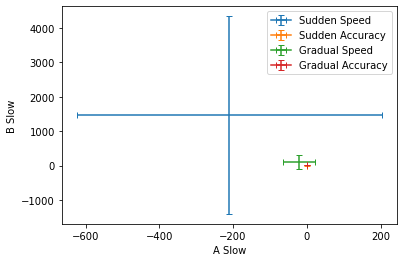

In [58]:
plot_fits(fit_Af, fit_Bf, "A Slow", "B Slow")

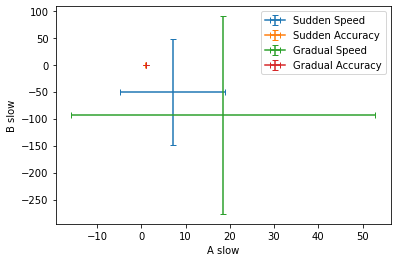

In [59]:
plot_fits(fit_As, fit_Bs, "A slow", "B slow")

In [ ]:
plot_fits(fit_transfer_A, fit_transfer_B)

In [15]:
def plot_collapsed_across_rotation_fits(fit_A, fit_B, x_label, y_label):
    x = np.array([np.mean(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),np.mean(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    y = np.array([np.mean(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0),np.mean(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])
    x_err = np.array([stat.sem(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),stat.sem(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    y_err = np.array([stat.sem(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0), stat.sem(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])
    #x_err = np.array([stat.tstd(np.concatenate((fit_A[0::4], fit_A[1::4])), axis = 0),stat.tstd(np.concatenate((fit_A[2::4], fit_A[3::4])), axis = 0)])
    #y_err = np.array([stat.tstd(np.concatenate((fit_B[0::4], fit_B[1::4])), axis = 0), stat.tstd(np.concatenate((fit_B[2::4], fit_B[3::4])), axis = 0)])

    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y

    #x_conf_interval = np.array(stat.norm.interval(0.95, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.95, loc = y, scale = y_err))
    #plt.errorbar(x, y, xerr = x_err, yerr = y_err, linestyle = 'None', capsize = 3)
    #plot0 = plt.errorbar(x[0], y[0], xerr = x_err[0], yerr = y_err[0], capsize = 3)
    #plot0 = plt.scatter(np.concatenate((fit_A[0::4], fit_A[1::4])), np.concatenate((fit_B[0::4], fit_B[1::4])))

    #plot1 = plt.errorbar(x[1], y[1], xerr = x_err[1], yerr = y_err[1], capsize = 3)
    #plot1 = plt.scatter(np.concatenate((fit_A[2::4], fit_A[3::4])), np.concatenate((fit_B[2::4], fit_B[3::4])))
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)

    #plot0 = plt.errorbar(x[0], y[0], xerr = x_conf_interval[:, 0], yerr = y_conf_interval[:, 0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_conf_interval[:, 1], yerr = y_conf_interval[:, 1], capsize = 3)
    #plot2 = plt.errorbar(x[2], y[2], xerr = x_conf_interval[:, 2], yerr = y_conf_interval[:, 2], capsize = 3)
    #plot3 = plt.errorbar(x[3], y[3], xerr = x_conf_interval[:, 3], yerr = y_conf_interval[:, 3], capsize = 3)

    plt.legend((plot0, plot1), ('Sudden', 'Gradual'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

[0.84655613] [0.5007307]


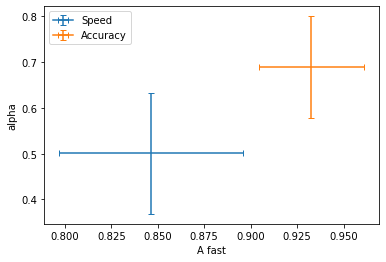

In [53]:
plot_collapsed_across_emphasis_fits(fit_As, fit_alpha, "A fast", "alpha")

In [19]:
def plot_collapsed_across_emphasis_fits(fit_A, fit_B, x_label, y_label):
    x = np.array([np.nanmean(fit_A[0::2, :], axis = 0), np.nanmean(fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    y = np.array([np.nanmean(fit_B[0::2, :], axis = 0), np.nanmean(fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])

    #x = np.array([np.nanmean(fit_A[0::2, :] - fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[1::2, :], axis = 0)])#, np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    #y = np.array([np.nanmean(fit_B[0::2, :] - fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[1::2, :], axis = 0)])#, np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])

    x_err = np.array([stat.sem(fit_A[0::2, :], axis = 0), stat.sem(fit_A[1::2, :], axis = 0)])#, stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    y_err = np.array([stat.sem(fit_B[0::2, :], axis = 0), stat.sem(fit_B[1::2, :], axis = 0)])#, stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])

    #x_err = np.array([stat.tstd(fit_A[0::2, :], axis = 0), stat.tstd(fit_A[1::2, :], axis = 0)])#, stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    #y_err = np.array([stat.tstd(fit_B[0::2, :], axis = 0), stat.tstd(fit_B[1::2, :], axis = 0)])#, stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])

    #x_conf_interval = np.array(stat.norm.interval(0.83, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.83, loc = y, scale = y_err))

    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)


    #plot0 = plt.errorbar(x[0], y[0], xerr = x_err[0], yerr = y_err[0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_err[1], yerr = y_err[1], capsize = 3)
    #plot0 = plt.errorbar(x[0], y[0], xerr = x_conf_interval[:, 0], yerr = y_conf_interval[:, 0], capsize = 3)
    #plot1 = plt.errorbar(x[1], y[1], xerr = x_conf_interval[:, 1], yerr = y_conf_interval[:, 1], capsize = 3)
    #plot2 = plt.errorbar(x[2], y[2], xerr = x_conf_interval[:, 2], yerr = y_conf_interval[:, 2], capsize = 3)
    #plot3 = plt.errorbar(x[3], y[3], xerr = x_conf_interval[:, 3], yerr = y_conf_interval[:, 3], capsize = 3)
    print (x[0], y[0])
    plt.legend((plot0, plot1), ('Speed', 'Accuracy'))#, 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

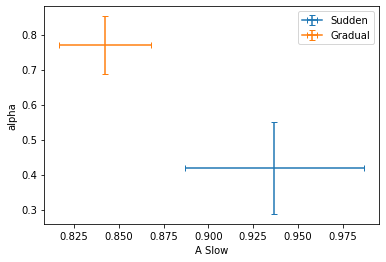

In [54]:
plot_collapsed_across_rotation_fits(fit_As, fit_alpha, "A Slow", "alpha")

In [ ]:
plot_collapsed_across_rotation_fits(fit_transfer_A, fit_transfer_B)

In [ ]:
#np.mean(np.mean(error_sum[1::4], axis = 2), axis = 0)
#stat.sem(np.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_param_fits(fit_A, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = np.array([np.mean(fit_A[1::4]),
                     np.mean(fit_A[0::4]), 
                     np.mean(fit_A[3::4]),
                     np.mean(fit_A[2::4])])# - np.mean(np.median(distances[1::4], axis = 2), axis = 0)[10],
    y_sem = np.array([stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4]),
                             stat.sem(fit_A[2::4])]) 
    #print (y_sem[0])
    #y_sem = np.array([0, 0, 0, 0])
    plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, fill = False)
    plt.bar(1, y[1], yerr = y_sem[1], capsize = 3, color = [0.5, 0.5, 0.5])
    plt.bar(2, y[2], yerr = y_sem[2], capsize = 3, hatch = '\\', fill = False)
    plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, hatch = '\\', color = [0.5, 0.5, 0.5])

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 1, 2, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('fit values')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    #plt.ylim(0, 45)
    print (y)
#np.shape(np.mean(error_sum[1::4], axis = 0))


[[[ 0.17996485 -0.00501206 -0.02302613 -0.11940731]
  [ 0.23885269  0.05387577  0.0358617  -0.06051947]
  [ 0.23156109  0.04658417  0.02857011 -0.06781107]
  [ 0.29597319  0.11099627  0.09298221 -0.00339897]]

 [[ 0.53361772  0.3486408   0.33062673  0.23424556]
  [ 0.47472988  0.28975296  0.2717389   0.17535772]
  [ 0.48202148  0.29704456  0.27903049  0.18264932]
  [ 0.41760938  0.23263246  0.21461839  0.11823722]]]
[0.35679128 0.17181437 0.1538003  0.05741913]
[array([0.17682643, 0.17682643, 0.17682643, 0.17682643]), array([-0.17682643, -0.17682643, -0.17682643, -0.17682643])]


ValueError: The lengths of the data (1) and the error 4 do not match

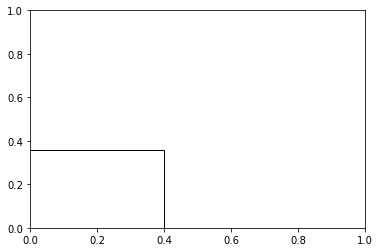

In [48]:
#np.mean(np.mean(error_sum[1::4], axis = 2), axis = 0)
#stat.sem(np.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_bar(distances, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = np.array([np.mean(distances[1::4]),# - np.mean(np.median(distances[1::4], axis = 2), axis = 0)[10],
                  np.mean(distances[0::4]), #- np.mean(np.median(distances[4::4], axis = 2), axis = 0)[10],
                  np.mean(distances[3::4]), #- np.mean(np.median(distances[3::4], axis = 2), axis = 0)[10],
                  np.mean(distances[2::4]) #- np.mean(np.median(distances[2::4], axis = 2), axis = 0)[10]] 
                  ])
    
    y_sem = np.array([stat.sem(distances[1::4]), 
                    stat.sem(distances[0::4]),
                    stat.sem(distances[3::4]),
                    stat.sem(distances[2::4])
                     ])
    print(np.array(stat.norm.interval(0.95, loc = y, scale = y_sem)))
    print(y)
    #x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_sem))#[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_sem))[1, :]
    #print (y_CI)
    #print (y_sem[0])
    #y_sem = np.array([0, 0, 0, 0])
    print([y_CI[0][0], y_CI[1][0]])
    plt.bar(0, y[0], yerr = y_CI[0][0], capsize = 3, fill = False)
    plt.bar(1, y[1], yerr = y_CI[0][1], capsize = 3, color = [0.5, 0.5, 0.5])
    plt.bar(2, y[2], yerr = y_CI[0][2], capsize = 3, hatch = '\\', fill = False)
    plt.bar(3, y[3], yerr = y_CI[0][3], capsize = 3, hatch = '\\', color = [0.5, 0.5, 0.5])

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 1, 2, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('Curvatures')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    plt.ylim(0, 45)
    print (y)
#np.shape(np.mean(error_sum[1::4], axis = 0))
plot_bar(fit_alpha, 'Transfer')

In [ ]:
def plot_errors_trials(num_points, first_trial, last_trial, errors, title_text):
    plt.figure(figsize=(20, 5))
    plot_0, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[0::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1), alpha = 0.5)
    plot_1, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[1::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1), alpha = 0.5)
    plot_2, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[2::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1))
    plot_3, = plt.plot(np.nanmean(np.split(np.ravel(np.nanmean(errors[3::4], axis = 0)[1:][:, first_trial:last_trial]), num_points), axis = 1))

    plt.legend((plot_0, plot_1, plot_2, plot_3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel('Trials')
    plt.ylabel('Angular Errors')
    plt.title(title_text)

# 2-state model

In [2]:
def dual_model_sudden(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    rotation = 90
    fast_est = np.zeros((num_trials))
    slow_est = np.zeros((num_trials))
    rotation_est = np.zeros((num_trials))
    #rotation_est[0] = est
    for trial in range(num_trials - 1):
        errors[trial] = rotation - rotation_est[trial]
        #print(errors[trial])
        fast_est[trial+1] = Af*fast_est[trial] + Bf*errors[trial]
        slow_est[trial+1] = As*slow_est[trial] + Bs*errors[trial]
        rotation_est[trial+1] = fast_est[trial+1] + slow_est[trial+1]
        #print (rotation_est)
    errors[num_trials-1] = rotation - rotation_est[num_trials-1]
    return errors, rotation_est, fast_est, slow_est

def dual_model_gradual(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    fast_est = np.zeros((num_trials))
    slow_est = np.zeros((num_trials))
    rotation_est = np.zeros((num_trials))
    rotation = 0
    for trial in range(num_trials - 1):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est[trial]
        #print(errors[trial])
        fast_est[trial+1] = Af*fast_est[trial] + Bf*errors[trial]
        slow_est[trial+1] = As*slow_est[trial] + Bs*errors[trial]
        rotation_est[trial+1] = fast_est[trial+1] + slow_est[trial+1]
        #print (rotation_est)
    errors[num_trials-1] = rotation - rotation_est[num_trials-1]
    return errors, rotation_est, fast_est, slow_est

In [3]:
def residuals_sudden(params, num_trials, data_errors):
    model_errors = dual_model_sudden(num_trials, params[0], params[1], params[2], params[3])[0]
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

def residuals_gradual(params, num_trials, data_errors):
    model_errors = dual_model_gradual(num_trials, params[0], params[1], params[2], params[3])[0]
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

In [4]:
def dual_model_transfer(num_trials, Af, Bf, As, Bs, est):
    errors = np.zeros((num_trials))
    rotation = 0
    fast_est = np.zeros((num_trials))
    slow_est = np.zeros((num_trials))
    rotation_est = np.zeros((num_trials))
    rotation_est[0] = est
    for trial in range(num_trials - 1):
        errors[trial] = rotation_est[trial] - rotation
        #print(errors[trial])
        fast_est[trial+1] = Af*fast_est[trial] + Bf*errors[trial]
        slow_est[trial+1] = As*slow_est[trial] + Bs*errors[trial]
        rotation_est[trial+1] = fast_est[trial+1] + slow_est[trial+1]
        #print (rotation_est)
    errors[num_trials-1] = rotation_est[num_trials-1] - rotation
    return errors, rotation_est, fast_est, slow_est

def residuals_sudden_transfer(params, num_trials, data_errors, est):
    model_errors = dual_model_transfer(num_trials, params[0], params[1], params[2], params[3], est)[0]
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    if params[0] > 1 or params[1] > 1 or params[2] > 1 or params[3] > 1:
        residual_error = residual_error + 10000000
    
    return residual_error


In [5]:
curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))


In [ ]:
def calc_curvature_wrapper(params):
    return calc_curvature(params[0], params[1], params[2], params[3])
paramlist = list(itertools.product(range(1000, 1060), range(12), range(64), range(1, 2)))

if __name__ == '__main__':
    pool = Pool()
    res = np.reshape(np.array(pool.map(workers.calc_curvature_wrapper, paramlist)), (60, 12, 64))

In [11]:
def fit_participant(participant, curvatures, num_fits):

    for fit_parts in range(num_fits):

        starting_points = np.array([[0.6, 0.5, 0.7, 0.1]])
        for initial_point in starting_points:
            if participant%4 == 0 or participant%4 == 1:      
                #fits = scipy.optimize.minimize(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')            
                fits = scipy.optimize.basinhopping(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'L-BFGS-B'})

                #if fits.fun < fit_V[participant][fit_parts]:
                Af = fits.x[0]#fit_Af[participant][fit_parts] = fits.x[0]
                Bf = fits.x[1]#fit_Bf[participant][fit_parts] = fits.x[1]
                As = fits.x[2]#fit_As[participant][fit_parts] = fits.x[2]
                Bs = fits.x[2]#fit_Bs[participant][fit_parts] = fits.x[3]
                V = fits.fun#fit_V[participant][fit_parts] = fits.fun
                #fit_success[participant][fit_parts] = fits.success                
            else:
                #fits = scipy.optimize.minimize(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')         
                fits = scipy.optimize.basinhopping(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'L-BFGS-B'})
                #if fits.fun < fit_V[participant][fit_parts]:
                Af = fits.x[0]#fit_Af[participant][fit_parts] = fits.x[0]
                Bf = fits.x[1]#fit_Bf[participant][fit_parts] = fits.x[1]
                As = fits.x[2]#fit_As[participant][fit_parts] = fits.x[2]
                Bs = fits.x[2]#fit_Bs[participant][fit_parts] = fits.x[3]
                V = fits.fun#fit_V[participant][fit_parts] = fits.fun
                #fit_success[participant][fit_parts] = fits.success
    return Af, Bf, As, Bs, V


In [12]:
#Divide the whole thing into 16 trial blocks and fit them
from functools import partial
def run_fits_dual(curvatures, num_trials, part_size):
    num_fits = int(num_trials/part_size)
    fit_As = np.zeros((60, num_fits))
    fit_Bs = np.zeros((60, num_fits))
    fit_Af = np.zeros((60, num_fits))
    fit_Bf = np.zeros((60, num_fits))
    fit_V = np.full((60, num_fits), np.inf)
    fit_success = np.zeros((60, num_fits))

    for participant in range(60):
        fit_Af[participant], fit_Bf[participant], fit_As[participant], fit_Bs[participant], fit_V[participant] = fit_participant(participant, curvatures, num_fits) 
        print (participant, fit_V[participant])
    #unc = partial(workers.fit_participant, curvatures = curvatures, num_fits = 1)
    #if __name__ == '__main__':
    #    pool = Pool()
    #res = np.reshape(np.array(pool.map(func, range(60))), (60, 5))
    return fit_Af, fit_Bf, fit_As, fit_Bs, fit_V
    #return res   

In [ ]:
Af, Bf, As, Bs, fit_V_dual = run_fits_dual(curvatures_smooth, 640, 640)
#fits = run_fits_dual(curvatures_smooth, 640, 640)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys

0 [nan]


In [228]:
#Divide the whole thing into 16 trial blocks and fit them
from functools import partial
def run_fits_dual_transfer(curvatures, num_trials, part_size):
    num_fits = int(num_trials/part_size)
    fit_As = np.zeros((60, num_fits))
    fit_Bs = np.zeros((60, num_fits))
    fit_Af = np.zeros((60, num_fits))
    fit_Bf = np.zeros((60, num_fits))
    fit_V = np.full((60, num_fits), np.inf)
    fit_success = np.zeros((60, num_fits))

    for participant in range(60):
        for fit_parts in range(num_fits):
            starting_points = np.array([[0.9, 0.2, 0.99, 0.02]])
            for initial_point in starting_points:
                #if participant%4 == 0 or participant%4 == 1:      
                    #fits = scipy.optimize.minimize(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')            
                fits = scipy.optimize.basinhopping(residuals_sudden_transfer, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (64, np.nan_to_num(np.ravel(curvatures[participant][-1:]), nan = np.nanmedian(curvatures[participant][-1:])), curvatures[participant, 10, -1]), 'method': 'Nelder-Mead'})

                #if fits.fun < fit_V[participant][fit_parts]:
                fit_Af[participant][fit_parts] = fits.x[0]
                fit_Bf[participant][fit_parts] = fits.x[1]
                fit_As[participant][fit_parts] = fits.x[2]
                fit_Bs[participant][fit_parts] = fits.x[3]
                fit_V[participant][fit_parts] = fits.fun
                #fit_success[participant][fit_parts] = fits.success                
                """
                else:
                    #fits = scipy.optimize.minimize(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')         
                    fits = scipy.optimize.basinhopping(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})
                    #if fits.fun < fit_V[participant][fit_parts]:
                    fit_Af[participant][fit_parts] = fits.x[0]
                    fit_Bf[participant][fit_parts] = fits.x[1]
                    fit_As[participant][fit_parts] = fits.x[2]
                    fit_Bs[participant][fit_parts] = fits.x[3]
                    fit_V[participant][fit_parts] = fits.fun
                    #fit_success[participant][fit_parts] = fits.success
                """
        print (participant, fit_V[participant])

    return fit_Af, fit_Bf, fit_As, fit_Bs, fit_V

In [229]:
Af_transfer, Bf_transfer, As_transfer, Bs_transfer, V_transfer = run_fits_dual_transfer(curvatures_smooth, 64, 64)

0 [17441.33483834]
1 [9659.25691382]
2 [10142.90009978]
3 [12153.73805181]
4 [2691.72761301]
5 [381.48738569]
6 [3772.18389406]
7 [25399.01882074]
8 [1864.47487678]
9 [916.52641432]
10 [6327.14300123]
11 [7285.74901312]
12 [5189.85263546]
13 [21416.27696898]
14 [1663.25182459]
15 [6199.51118377]
16 [11841.13717537]
17 [507.28180989]
18 [7654.26431655]
19 [4836.80107998]
20 [19790.1758355]
21 [325.42013155]
22 [21409.02568292]
23 [638.33192724]
24 [993.18984839]
25 [7129.41920381]
26 [6717.57122046]
27 [31007.87801692]
28 [6311.45199182]
29 [1886.88720171]
30 [2392.04934631]
31 [7455.19882008]
32 [6412.48664794]
33 [10743.68982734]
34 [5047.04379072]
35 [327.60175181]
36 [7974.12207424]
37 [1931.4946209]
38 [28587.85757122]
39 [5264.89605646]
40 [1210.75414078]
41 [146.00355528]
42 [10911.81745223]
43 [1921.58612892]
44 [1102.02888604]
45 [15607.62293428]
46 [6871.99112613]
47 [5430.20008591]
48 [60.03425052]
49 [9404.72693159]
50 [20803.67607488]
51 [6907.91551795]
52 [2305.49671547]
5

# Parameter Fits

In [ ]:
plot_fits(Af_rts, m_rts, "A slow", "m")

## Collapse Across Sudden Gradual

In [ ]:
plot_collapsed_across_rotation_fits(m_rts, Af, "m", "Af")

## Collapsing across Speed/Accuracy

In [ ]:
plot_collapsed_across_emphasis_fits (As, alpha_rts, "As", "alpha")

In [ ]:
fit_V_single_state = fit_V


In [ ]:
np.mean(fit_transfer_V)

In [55]:
np.mean(fit_V)

97851.52262105554

In [ ]:
np.mean(fit_V_dual)

# % Variance accounted for

In [93]:
1 - np.sum(fit_transfer_V)/np.nansum((np.ravel(curvatures[:, 11, :]) - np.nanmean(curvatures[:, 11, :]))**2)

NameError: name 'fit_transfer_V' is not defined

In [ ]:
import pickle
f = open('fit_V_dual.pickle', 'rb')
fit_V_dual, Af, Bf, As, Bs, m= pickle.load(f)

In [56]:
1 - np.sum(fit_V)/np.nansum((np.ravel(curvatures_smooth[:, 1:-1, :]) - np.nanmean(curvatures_smooth[:, 1:-1, :]))**2)

0.5295996378936266

In [10]:
fpe = ((1+(5/640))/(1 - (5/640)))*np.mean(fit_V)
fpe

74598.5156813702

In [ ]:
plt.figure(figsize = (20, 10))
errors_predict = np.zeros((60, 704))

for participant in range(60):
    if participant % 4 == 0 or participant%4 == 1:
        errors_predict[participant][:640] = base_model_sudden(640, fit_A[participant], fit_B[participant])
#num_trials, Af, Bf, As, Bs
#        errors_predict[participant][:640] = dual_model_sudden(640, Af[participant], Bf[participant], As[participant], Bs[participant])

    else:    
#        errors_predict[participant][:640] = dual_model_gradual(640, Af[participant], Bf[participant], As[participant], Bs[participant])
        errors_predict[participant][:640] = base_model_gradual(640, fit_A[participant], fit_B[participant])

#    errors_predict[participant][640:] = dual_model_transfer(64, Af[participant], Bf[participant], As[participant], Bs[participant])
    errors_predict[participant][640:] = base_model_transfer(64, fit_A[participant], fit_B[participant], np.nanmean(curvatures[participant][10][-16:]))

for participant in range(4):
    if participant % 4 == 0 or participant%4 == 1:
        plt.subplot(4, 1, participant + 1 )
        y_err = np.array(stat.norm.interval(0.95, loc = y, scale = y_err))
        y_err = np.m
        plt.plot(np.mean(errors_predict[participant::4], axis = 0))
        plt.plot(np.ravel(np.mean(curvatures_smooth[participant::4], axis = 0)[1:]))
    else:
        plt.subplot(4, 1, participant + 1 )
        plt.plot(np.mean(errors_predict[participant::4], axis = 0))
        plt.plot(np.ravel(np.mean(curvatures_smooth[participant::4], axis = 0)[1:]))
    plt.ylim((0, 100))


In [26]:
import pandas as pd

In [35]:
df_A = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_A": fit_Af[:, 0]})

model_A = ols('fit_A ~ C(Emphasis)*C(Rotation)', data = df_A).fit()

aov_table_A = sm.stats.anova_lm(model_A)


df_B = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_B": fit_Bf[:, 0]})

model_B = ols('fit_B ~ C(Emphasis)*C(Rotation)', data = df_B).fit()
aov_table_B = sm.stats.anova_lm(model_B)

df_alpha = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_alpha": fit_alpha[:, 0]})

model_alpha = ols('fit_alpha ~ C(Emphasis)*C(Rotation)', data = df_alpha).fit()
aov_table_alpha = sm.stats.anova_lm(model_alpha)



In [36]:
aov_table_B

,df,sum_sq,mean_sq,F,PR(>F)
C(Emphasis),1.0,3.135053,3.135053,0.425746,0.516753
C(Rotation),1.0,0.876162,0.876162,0.118985,0.731431
C(Emphasis):C(Rotation),1.0,2.342454,2.342454,0.318110,0.574998
Residual,56.0,412.365193,7.363664,NaN,NaN


In [37]:
aov_table_A

,df,sum_sq,mean_sq,F,PR(>F)
C(Emphasis),1.0,0.968045,0.968045,9.521726,0.003153
C(Rotation),1.0,0.007099,0.007099,0.069827,0.792558
C(Emphasis):C(Rotation),1.0,0.132414,0.132414,1.302431,0.258626
Residual,56.0,5.693352,0.101667,NaN,NaN


In [38]:
aov_table_alpha

,df,sum_sq,mean_sq,F,PR(>F)
C(Emphasis),1.0,0.296859,0.296859,4.710438,0.034237
C(Rotation),1.0,0.377753,0.377753,5.994026,0.017513
C(Emphasis):C(Rotation),1.0,0.029435,0.029435,0.467055,0.497163
Residual,56.0,3.529204,0.063022,NaN,NaN


Effect of emphasis on As

Effect of rotation and emphasis on Bf

# State Space model for RT data

In [ ]:
num_trials = 640
def base_model_sudden(num_trials, RT, A, B, m):
 #   A = np.exp(A)/(1 + np.exp(A))
 #   B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation = 90
    rotation_est = 0
    for trial in range(num_trials - 1):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        #rotation_est = A*rotation_est + B*(1 - np.exp(-m*RT[trial+1]))*errors[trial]# + m*RT[trial+1]
        rotation_est = A*rotation_est + B*errors[trial] + m*RT[trial+1]
 
    #print (rotation_est)
    errors[trial+1] = rotation - rotation_est
    
    return errors

def base_model_gradual(num_trials, RT, A, B, m):
#    A = np.exp(A)/(1 + np.exp(A))
#    B = np.exp(B)/(1 + np.exp(B))
    
    errors = np.zeros((num_trials))
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials - 1):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
#        rotation_est = A*rotation_est + B*(1 - np.exp(-m*RT[trial+1]))*errors[trial]# + m*RT[trial+1]
        rotation_est = A*rotation_est + B*errors[trial] + m*RT[trial+1]

        #print (rotation_est)
    errors[trial+1] = rotation - rotation_est

    return errors

def residuals_base_sudden(params, num_trials, data_errors, RTs):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_sudden(num_trials, RTs, params[0], params[1], params[2])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0:# or params[2] < 0:# or params[3] < 0:
        residual_error = residual_error + 1000000
    if params[0] > 1 or params[1] > 1:# or params[2] > 1:# or params[3] < 0:
        residual_error = residual_error + 1000000

    return residual_error

def residuals_base_gradual(params, num_trials, data_errors, RTs):
#   model_errors = base_model_sudden(num_trials, params[0], params[1])
    model_errors = base_model_gradual(num_trials, RTs, params[0], params[1], params[2])
    residual_error = np.sum(np.square(model_errors - data_errors))
    #if params[0] > params[2]:
    #    residual_error = residual_error + 1000000
    #if params[1] < params[3]:
    #    residual_error = residual_error + 1000000
    if params[0] < 0 or params[1] < 0:# or params[2] < 0:# or params[3] < 0:
        residual_error = residual_error + 1000000
    if params[0] > 1 or params[1] > 1:# or params[2] > 1:# or params[3] < 0:
        residual_error = residual_error + 1000000

    return residual_error

# Read RT Data

In [ ]:
def times(data, block):
    initial_time = scipy.io.loadmat('data/data{data}/initial_time/initial_time{block}.mat'.format(block=str(block), data=str(data)))
    movement_time = scipy.io.loadmat('data/data{data}/movement_time/movement_time{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    initial_time = initial_time['initial_time'][:, 0]
    movement_time = movement_time['movement_time'][:, 0]
    return initial_time, movement_time
def get_times():
    initial_times = np.zeros((60, 12, 64))
    movement_times = np.zeros((60, 12, 64))
    for participant in range(60):
        for block in range(12):
            it, mt = times(participant+1000, block)
            initial_times[participant, block] = it
            movement_times[participant, block] = mt
    return initial_times, movement_times
its, mts = get_times()

In [ ]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits(curvatures, RTs, num_trials, part_size, first):
    num_parts = int((num_trials-first)/part_size)
    fit_A = np.zeros((60, num_parts))
    fit_B = np.zeros((60, num_parts))
    fit_m = np.zeros((60, num_parts))
    fit_bias = np.zeros((60, num_parts))
    fit_V = np.full((60, num_parts), np.inf)
    fit_success = np.zeros((60, num_parts))
    fit_num = 0
    #starting_points = np.array([[0.5, 0.6], [0.4, 0.7], [0.3, 0.8], [0.2, 0.9], [0.1, 0.99], [0.9, 0.2], [0.99, 0.1], [0.8, 0.3], [0.7, 0.4], [0.6, 0.5]])
    
    #A = np.log(params[0]/(1-params[0]))
    #B = np.log(params[1]/(1-params[1]))

#    starting_points = np.array([[np.log(0.999/(1 - 0.999)), np.log(0.002/(1 - 0.002))]])
    starting_points = np.array([[0.999, 0.002, 0.1]])

    for curr_trial in range(first, num_trials, part_size):
        for participant in range(60):
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:
                #print (np.nan_to_num(np.ravel(curvatures[participant])[first:first+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[first:first+part_size])))
                #popt, pcov = curve_fit(base_model_sudden, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_sudden, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), np.nan_to_num(np.ravel(RTs[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(RTs[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize=0.05)
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_m[participant][fit_num] = fits.x[2]
                        #fit_bias[participant][fit_num] = fits.x[2]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success   
                    
                else:
                    #popt, pcov = curve_fit(base_model_gradual, part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), bounds=((0, 0), (1, np.inf)))
                    #fits = scipy.optimize.minimize(residuals_base_gradual, x0 = [initial_point[0], initial_point[1]], args = (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size]))), method = 'Nelder-Mead')
                    fits = scipy.optimize.basinhopping(residuals_base_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2]], minimizer_kwargs={'args': (part_size, np.nan_to_num(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(curvatures[participant])[curr_trial:curr_trial+part_size])), np.nan_to_num(np.ravel(its[participant])[curr_trial:curr_trial+part_size], nan = np.nanmedian(np.ravel(RTs[participant])[curr_trial:curr_trial+part_size]))), 'method': 'Nelder-Mead'}, stepsize = 0.05)
                    
                    if fits.fun < fit_V[participant][fit_num]:
                        fit_A[participant][fit_num] = fits.x[0]
                        fit_B[participant][fit_num] = fits.x[1]
                        fit_m[participant][fit_num] = fits.x[2]
                        #fit_bias[participant][fit_num] = fits.x[2]
                        fit_V[participant][fit_num] = fits.fun
                        #fit_success[participant][fit_num] = fits.success
                print (participant, fits.fun)

        fit_num = fit_num + 1
    return fit_A, fit_B, fit_m, fit_V
        

In [ ]:
fit_A, fit_B, fit_m, fit_V = run_fits(curvatures_smooth, its, 704, 640, 64)

In [ ]:
def plot_data_vs_fits(its, fit_A, fit_B, fit_m):
    plt.figure(figsize = (20, 10))
    errors_predict = np.zeros((60, 704))

    for participant in range(60):
        if participant % 4 == 0 or participant%4 == 1:
            errors_predict[participant][:640] = base_model_sudden(640,np.ravel(its[participant][1:-1]), fit_A[participant], fit_B[participant], fit_m[participant])

        else:    
            errors_predict[participant][:640] = base_model_gradual(640, np.ravel(its[participant][1:-1]), fit_A[participant], fit_B[participant], fit_m[participant])

        #errors_predict[participant][640:] = base_model_transfer(64, fit_A[participant], fit_B[participant])

    for participant in range(4):
        if participant % 4 == 0 or participant%4 == 1:
            plt.subplot(4, 1, participant + 1 )
            plt.plot(np.mean(errors_predict[participant::4], axis = 0))
            plt.plot(np.ravel(np.mean(curvatures_smooth[participant::4], axis = 0)[1:]))
        else:
            plt.subplot(4, 1, participant + 1 )
            plt.plot(np.mean(errors_predict[participant::4], axis = 0))
            plt.plot(np.ravel(np.mean(curvatures_smooth[participant::4], axis = 0)[1:]))
        plt.ylim((0, 100))


In [ ]:
plot_data_vs_fits(its, fit_A, fit_B, fit_m)

In [ ]:
def plot_fits(fit_A, fit_B, x_label, y_label):
    x = np.array([np.nanmean(fit_A[0::4, :], axis = 0), np.nanmean(fit_A[1::4, :], axis = 0), np.nanmean(fit_A[2::4, :], axis = 0), np.nanmean(fit_A[3::4, :], axis = 0)])
    y = np.array([np.nanmean(fit_B[0::4, :], axis = 0), np.nanmean(fit_B[1::4, :], axis = 0), np.nanmean(fit_B[2::4, :], axis = 0), np.nanmean(fit_B[3::4, :], axis = 0)])
    x_err = np.array([stat.sem(fit_A[0::4, :], axis = 0), stat.sem(fit_A[1::4, :], axis = 0), stat.sem(fit_A[2::4, :], axis = 0), stat.sem(fit_A[3::4, :], axis = 0)])
    y_err = np.array([stat.sem(fit_B[0::4, :], axis = 0), stat.sem(fit_B[1::4, :], axis = 0), stat.sem(fit_B[2::4, :], axis = 0), stat.sem(fit_B[3::4, :], axis = 0)])
    #x_err = np.array([stat.tstd(fit_A[0::4, :], axis = 0), stat.tstd(fit_A[1::4, :], axis = 0), stat.tstd(fit_A[2::4, :], axis = 0), stat.tstd(fit_A[3::4, :], axis = 0)])
    #y_err = np.array([stat.tstd(fit_B[0::4, :], axis = 0), stat.tstd(fit_B[1::4, :], axis = 0), stat.tstd(fit_B[2::4, :], axis = 0), stat.tstd(fit_B[3::4, :], axis = 0)])

    #x_conf_interval = np.array(stat.norm.interval(0.83, loc = x, scale = x_err))
    #y_conf_interval = np.array(stat.norm.interval(0.83, loc = y, scale = y_err))
    x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[0, :], np.array(stat.norm.interval(0.95, loc = y, scale = y_err))[1, :] - y


    #print (x_conf_interval[:, 0])
    #plt.errorbar(x, y, xerr = x_err, yerr = y_err, linestyle = 'None', capsize = 3)
    plot0 = plt.errorbar(x[0], y[0], xerr = [x_CI[0][0], x_CI[1][0]], yerr = [y_CI[0][0], y_CI[1][0]], capsize = 3)
    plot1 = plt.errorbar(x[1], y[1], xerr = [x_CI[0][1], x_CI[1][1]], yerr = [y_CI[0][1], y_CI[1][1]], capsize = 3)
    plot2 = plt.errorbar(x[2], y[2], xerr = [x_CI[0][2], x_CI[1][2]], yerr = [y_CI[0][2], y_CI[1][2]], capsize = 3)
    plot3 = plt.errorbar(x[3], y[3], xerr = [x_CI[0][3], x_CI[1][3]], yerr = [y_CI[0][3], y_CI[1][3]], capsize = 3)

    #plot0 = plt.scatter(fit_A[0::4], fit_B[0::4])
    #plot1 = plt.scatter(fit_A[1::4], fit_B[1::4])
    #plot2 = plt.scatter(fit_A[2::4], fit_B[2::4])
    #plot3 = plt.scatter(fit_A[3::4], fit_B[3::4])

    plt.legend((plot0, plot1, plot2, plot3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [ ]:
#plot_fits(np.reshape(np.mean(np.nanmedian(its, axis = 2), axis = 1), (60, 1)), fit_m, "Mean ITs", "fit_m")
#with plt.xkcd():
plot_fits(Bs, alpha, "fit_B", "alpha")

## Adding RT to dual state model

In [ ]:
def dual_model_sudden_rts(num_trials, rts, Af, Bf, As, Bs, alpha):
    errors = np.zeros((num_trials))
    rotation = 90
    fast_est = 0
    slow_est = 0
    rotation_est = fast_est + slow_est
    for trial in range(num_trials - 1):
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        #Adding alpha to see relative contributions of the fast and the slow systems
        rotation_est = alpha*fast_est + (1-alpha)*slow_est# + m*rts[trial+1]
        #print (rotation_est)
    errors[trial+1] = rotation - rotation_est
    return errors

def dual_model_gradual_rts(num_trials, rts, Af, Bf, As, Bs, alpha):
    errors = np.zeros((num_trials))
    fast_est = 0
    slow_est = 0
    rotation_est = 0
    rotation = 0
    for trial in range(num_trials-1):
        if trial%64 == 0:
            rotation = rotation + 10
        if rotation > 90:
            rotation = 90
        errors[trial] = rotation - rotation_est
        #print(errors[trial])
        #Adding alpha to see relative contributions of the fast and the slow systems
        fast_est = Af*fast_est + Bf*errors[trial]
        slow_est = As*slow_est + Bs*errors[trial]
        rotation_est = alpha*fast_est + (1-alpha)*slow_est# + m*rts[trial+1]
        #print (rotation_est)
    errors[trial+1] = rotation - rotation_est
    return errors


In [ ]:
def residuals_sudden_rts(params, num_trials, data_errors, rts):
    model_errors = dual_model_sudden_rts(num_trials, rts, params[0], params[1], params[2], params[3], params[4])#, params[5])
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:# or params[4] < 0:
        residual_error = residual_error + 10000000
    if params[0] > 1 or params[1] > 1 or params[2] > 1 or params[3] > 1:# or params[4] < 0:
        residual_error = residual_error + 10000000
    if params[4] < 0 or params[4] > 1:
        residual_error = residual_error+100000000
    return residual_error

def residuals_gradual_rts(params, num_trials, data_errors, rts):
    model_errors = dual_model_gradual_rts(num_trials, rts, params[0], params[1], params[2], params[3], params[4])#, params[5])
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:# or params[4] < 0:
        residual_error = residual_error + 10000000
    if params[0] > 1 or params[1] > 1 or params[2] > 1 or params[3] > 1:# or params[4] < 0:
        residual_error = residual_error + 10000000

    if params[4] < 0 or params[4] > 1:
        residual_error = residual_error+100000000

    return residual_error

In [ ]:
#Divide the whole thing into 16 trial blocks and fit them
def run_fits_dual_rts(curvatures, rts, num_trials, part_size):
    num_fits = int(num_trials/part_size)
    fit_As = np.zeros((60, num_fits))
    fit_Bs = np.zeros((60, num_fits))
    fit_Af = np.zeros((60, num_fits))
    fit_Bf = np.zeros((60, num_fits))
    fit_V = np.full((60, num_fits), np.inf)
    #fit_m = np.zeros((60, num_fits))
    fit_alpha = np.zeros((60, num_fits))
    fit_success = np.zeros((60, num_fits))

    for participant in range(60):
        for fit_parts in range(num_fits):
            #starting_points = np.array([[fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.9, 0.2], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.99, 0.1], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.8, 0.3], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.7, 0.4], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.6, 0.5], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.5, 0.6], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.4, 0.7], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.3, 0.8], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.2, 0.9], [fit_A[participant][fit_parts], fit_B[participant][fit_parts], 0.1, 0.99],
            #                [0.9, 0.2, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.99, 0.1, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.8, 0.3, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.7, 0.4, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.6, 0.5, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.5, 0.6, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.4, 0.7, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.3, 0.8, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.2, 0.9, fit_A[participant][fit_parts], fit_B[participant][fit_parts]], [0.1, 0.99, fit_A[participant][fit_parts], fit_B[participant][fit_parts]]])
            #starting_points = np.array([[0.9, 0.2, 0.99, 0.02], [0.8, 0.3, 0.9, 0.03], [0.7, 0.4, 0.8, 0.04], [0.6, 0.5, 0.7, 0.05]])
            starting_points = np.array([[0.9, 0.2, 0.99, 0.02, 0.5]])
            for initial_point in starting_points:
                if participant%4 == 0 or participant%4 == 1:      
                    #fits = scipy.optimize.minimize(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')            
                    fits = scipy.optimize.basinhopping(residuals_sudden_rts, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3], initial_point[4]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1])), np.ravel(rts[participant][1:-1])), 'method': 'Nelder-Mead'})
                    
                    if fits.fun < fit_V[participant][fit_parts]:
                        fit_Af[participant][fit_parts] = fits.x[0]
                        fit_Bf[participant][fit_parts] = fits.x[1]
                        fit_As[participant][fit_parts] = fits.x[2]
                        fit_Bs[participant][fit_parts] = fits.x[3]
                        #fit_m[participant][fit_parts] = fits.x[4]
                        fit_alpha[participant][fit_parts] = fits.x[4]
                        fit_V[participant][fit_parts] = fits.fun
                        #fit_success[participant][fit_parts] = fits.success                
                else:
                    #fits = scipy.optimize.minimize(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')         
                    fits = scipy.optimize.basinhopping(residuals_gradual_rts, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3], initial_point[4]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1])), np.ravel(rts[participant][1:-1])), 'method': 'Nelder-Mead'})
                    if fits.fun < fit_V[participant][fit_parts]:
                        fit_Af[participant][fit_parts] = fits.x[0]
                        fit_Bf[participant][fit_parts] = fits.x[1]
                        fit_As[participant][fit_parts] = fits.x[2]
                        fit_Bs[participant][fit_parts] = fits.x[3]
                        #fit_m[participant][fit_parts] = fits.x[4]
                        fit_alpha[participant][fit_parts] = fits.x[4]
                        fit_V[participant][fit_parts] = fits.fun
                        #fit_success[participant][fit_parts] = fits.success

        print (participant, fits.fun)
    return fit_Af, fit_Bf, fit_As, fit_Bs, fit_alpha, fit_V, fit_success
        

In [ ]:
Af, Bf, As, Bs, alpha, fit_V_dual, fit_success_dual = run_fits_dual_rts(curvatures_smooth, its, 640, 640)

In [ ]:
df_A = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_A": Af_rts[:, 0]})

model_A = ols('fit_A ~ C(Emphasis)*C(Rotation)', data = df_A).fit()

aov_table_A = sm.stats.anova_lm(model_A)


df_B = pd.DataFrame({"Emphasis": np.tile(["Speed", "Accuracy"], 30),
                   "Rotation": np.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "fit_B": Bf_rts[:, 0]})

model_B = ols('fit_B ~ C(Emphasis)*C(Rotation)', data = df_B).fit()
aov_table_B = sm.stats.anova_lm(model_B)


In [ ]:
aov_table_B

# Save Params

In [9]:
import pickle


In [ ]:
with open('fit_dual_additive_unbound_alphaed.pickle', 'wb') as f:
    pickle.dump([fit_V_dual_rts, Af_rts, Bf_rts, As_rts, Bs_rts, m_rts, alpha_rts], f)
f.close()

# Load Params

In [18]:
params = pickle.load(open('fit_dual_additive_bound.pickle', 'rb'))

In [27]:
np.shape(params[1])

(60, 1)

In [379]:
def plot_data_vs_fits(Af, Bf, As, Bs):
    plt.figure(figsize = (20, 10))
    errors_predict = np.zeros((60, 704))
    fast = np.zeros((60, 704))
    slow = np.zeros((60, 704))
    rotation_est = np.zeros((60, 704))
    for participant in range(60):
        if participant % 4 == 0 or participant%4 == 1:
            errors_predict[participant][:640], rotation_est[participant][:640], fast[participant][:640], slow[participant][:640] = dual_model_sudden(640, Af[participant], Bf[participant], As[participant], Bs[participant])

        else:    
            errors_predict[participant][:640], rotation_est[participant][:640], fast[participant][:640], slow[participant][:640] = dual_model_gradual(640, Af[participant], Bf[participant], As[participant], Bs[participant])

        errors_predict[participant][640:], rotation_est[participant][640:], fast[participant][640:], slow[participant][640:] = dual_model_transfer(64, Af[participant], Bf[participant], As[participant], Bs[participant], rotation_est[participant][639])
        #rotation_est[participant][640:] = -rotation_est[participant][640:]
    #print (rotation_est[participant-2][639], rotation_est[participant-2][640])
    #print (rotation_est[1][640:])    
    for participant in range(4):
        if participant % 4 == 0 or participant%4 == 1:
            plt.subplot(4, 1, participant + 1 )
            #plt.plot(np.nanmean(errors_predict[participant::4], axis = 0))
            #plt.plot(np.nanmean(rotation_est[participant::4], axis = 0))
            #plt.plot(np.nanmean(fast[participant::4], axis = 0))
            #plt.plot(np.nanmean(slow[participant::4], axis = 0))
            plt.plot(np.append(np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[:-1]), np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
        else:
            plt.subplot(4, 1, participant + 1 )
            #plt.plot(np.nanmean(errors_predict[participant::4], axis = 0))    
            #plt.plot(np.nanmean(rotation_est[participant::4], axis = 0))
            #plt.plot(np.nanmean(fast[participant::4], axis = 0))
            #plt.plot(np.nanmean(slow[participant::4], axis = 0))
            plt.plot(np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[:]))
        plt.ylim((-100, 150))


In [380]:
np.ravel(np.nanmean(curvatures_smooth[0::4], axis = 0)[11])

array([40.23583015, 37.92847018, 34.56502122, 31.68024595, 29.90288821,
       29.08774572, 28.56687397, 27.77484008, 26.63694095, 25.51689751,
       24.86215972, 24.83344412, 25.17809661, 25.43401219, 25.15013473,
       24.55876947, 23.96487786, 23.7284669 , 23.89798112, 24.57186948,
       24.75994767, 24.80580831, 24.8471142 , 26.55001979, 26.52548833,
       25.97770119, 24.61406681, 22.41665178, 19.78902255, 17.39878147,
       16.85666252, 16.60076639, 15.4740755 , 14.5098216 , 13.91926785,
       13.70938563, 13.73046168, 13.94328282, 14.38301065, 14.92339027,
       15.29030231, 16.34104577, 15.99967211, 15.54198076, 15.08793066,
       14.58977724, 13.9530373 , 12.45518059, 12.0002167 , 11.84474234,
       11.99367436, 12.31254712, 12.63467286, 12.85140406, 12.93239239,
       12.09413022, 12.18488314, 12.44488386, 12.34466356, 12.07478062,
       11.0781899 ,  9.57219442,  8.13810365,  7.29931475])

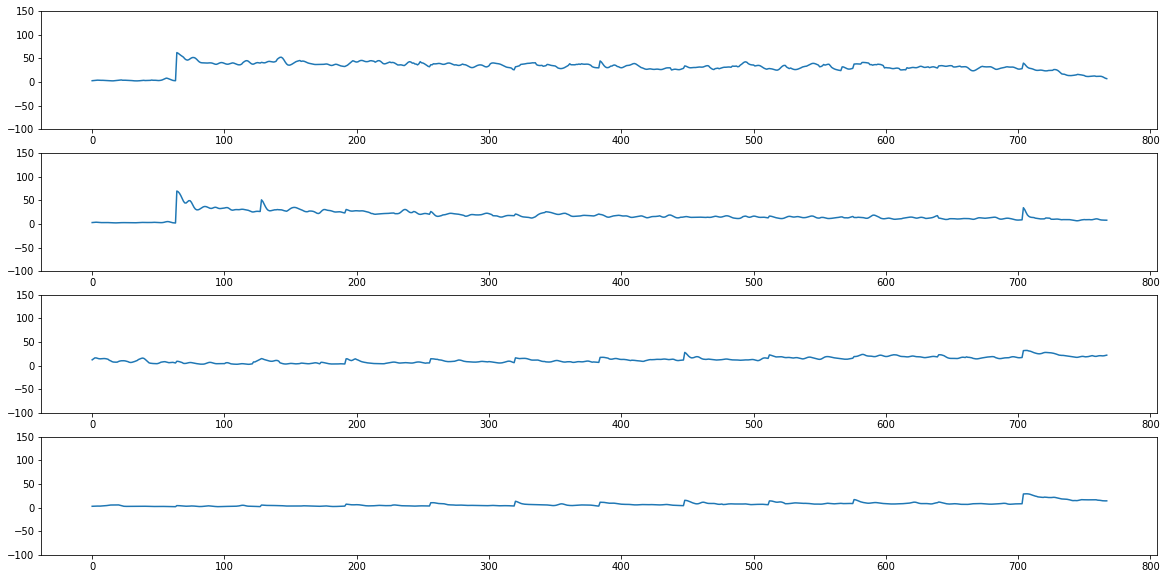

In [381]:
plot_data_vs_fits(params[1], params[2], params[3], params[4])

# Direction-Wise analysis

In [ ]:
def get_targets():
    targets = np.zeros((60, 12, 64))
    for data in range(1000, 1060):
        for block in range(12):
            target_load = scipy.io.loadmat('data/data{data}/squares/squares{block}.mat'.format(block=str(block), data=str(data)))
            targets[data-1000][block][:]= target_load['squares'][0]
    return targets

In [ ]:
targets = get_targets()

In [ ]:
def target_specific_measures(targets, measure):
    target_measure = np.zeros((60, 12, 4, 16), dtype = measure.dtype)
    for participant in range(60):
        for block in range(12):
            for target_loc in range(4):
                target_measure[participant][block][target_loc] = measure[participant][block][np.where(targets[participant][block] == np.unique(targets[participant][block])[target_loc])]
    return target_measure

In [ ]:
target_curvatures = target_specific_measures(targets, curvatures)
target_its = target_specific_measures(targets, its)
target_mts = target_specific_measures(targets, mts)

In [ ]:
def difference_in_directions(condition, direction_considered, target_measure, title_text, y_label):
    permutation = list()
    permutation.append(direction_considered)
        
    for i in range(4):
        if i == direction_considered:
            continue
        else:
            permutation.append(i)
    print (permutation)
    idx = np.empty_like(permutation)
    idx[permutation] = np.arange(len(permutation))

    plot0, = plt.plot(np.ravel(np.nanmean(target_measure[condition::4, :, direction_considered, :], axis = 0)))
    rearanged_measure = target_measure[:, :, idx, :]
    plot1, = plt.plot(np.ravel(np.nanmean(np.mean(rearanged_measure[condition::4, :, 1:, :], axis = 0), axis = 1)))
    plt.legend((plot0, plot1), ('Direction Considered', 'Mean of other directions'))
    plt.title(title_text)
    plt.xlabel('trials')
    plt.ylabel(y_label)


In [ ]:
plot0, = plt.plot(np.ravel(np.mean(target_curvatures[3::4, :, 0, :], axis = 0)))
plot1, = plt.plot(np.ravel(np.mean(np.mean(target_curvatures[3::4, :, 1:, :], axis = 0), axis = 1)))
plt.legend((plot0, plot1), ('45 Degrees from Abscissa', 'Mean of other directions'))

In [ ]:
difference_in_directions(condition = 0, direction_considered=3, target_measure=target_curvatures, title_text='Direction Considered: 315', y_label='Angular Errors')

In [ ]:
permutation = [1, 0, 2, 3]
idx = np.empty_like(permutation)
idx[permutation] = np.arange(len(permutation))


In [ ]:
np.mean(target_mts[2::4, :, 0, :])

In [ ]:
np.mean(target_mts[2::4, :, 2, :])

# Calculating Speed

In [ ]:
def get_dist():
    distances = np.zeros((60, 12, 64))
    within_distances = np.zeros((60, 12, 64), dtype = object)
    for data in range(60):
        for block in range(12):
            traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data+1000)))
            for trial in range(64):
                trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
                trajx = trajx.astype('float64')
                trajy = trajy.astype('float64')
            
                distance_covered = 0
                within_distance_covered = list()
                for i in range(len(trajx[:-1])):
                    #print (trajx[i], trajy[i])
                    distance_covered = distance_covered + np.sqrt((trajx[i+1] - trajx[i])**2 + (trajy[i+1] - trajy[i])**2)
                    within_distance_covered.append(np.sqrt((trajx[i+1] - trajx[i])**2 + (trajy[i+1] - trajy[i])**2))
                distances[data][block][trial] = distance_covered
                within_distances[data][block][trial] = within_distance_covered
    return distances, within_distances

In [ ]:
distances, within_distances = get_dist()

In [ ]:
dist_error = distances - np.sqrt(212**2 + 212**2)

In [ ]:
target_distances = target_specific_measures(targets, distances)
target_dist_error = target_specific_measures(targets, dist_error)


In [ ]:
difference_in_directions(condition = 0, direction_considered=3, target_measure=target_dist_error, title_text='Direction Considered: 315', y_label='Distance Covered')

In [ ]:
speed = distances/mts

In [ ]:
target_speed = target_specific_measures(targets, speed)

In [ ]:
difference_in_directions(condition = 0, direction_considered=0, target_measure=target_curvatures, title_text='Direction Considered: 45', y_label='Angular Error')

In [ ]:
data = 1004
block = 2
trial = 2
speeds_list = list()

speeds = np.zeros((60, 12, 64), dtype = object)
accelerations = np.zeros((60, 12, 64), dtype = object)
for data in range(1000, 1060):
    for block in range(12):
        #traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
        for trial in range(64):    
            #x_grad = np.gradient(traj['x'][0][trial][0])
            #y_grad = np.gradient(traj['y'][0][trial][0])
            #x_grad = x_grad.astype('float64')
            #y_grad = y_grad.astype('float64')
            #x_grad_grad = np.gradient(x_grad)
            #y_grad_grad = np.gradient(y_grad)
            try:
                speed = np.abs(np.gradient(np.cumsum(within_distances[data-1000][block][trial])))
                acceleration = np.gradient(speed)
            except:
                speed = 0
                acceleration = 0
            #speed = np.sqrt(x_grad**2 + y_grad**2)
            #acceleration = np.sqrt(x_grad_grad**2 + y_grad_grad**2)
            speeds[data-1000][block][trial] = speed
            accelerations[data - 1000][block][trial] = acceleration

In [ ]:
target_specific_speeds = target_specific_measures(targets, speeds)
target_specific_accelerations = target_specific_measures(targets, accelerations)

In [ ]:
speed_chunked_means = np.zeros((60, 12, 4, 16, 5))
speed_chunked_medians = np.zeros((60, 12, 4, 16, 5))

for participant in range(60):
    for block in range(12):
        for direction in range(4):
            for trial in range(16):
                chunk_size = int(np.floor(len(target_specific_speeds[participant][block][direction][trial])/5))
                for chunks in range(5):
                    speed_chunked_means[participant][block][direction][trial][chunks] = np.nanmean(target_specific_speeds[participant][block][direction][trial][chunk_size*chunks:chunk_size*(chunks+1)])
                    speed_chunked_medians[participant][block][direction][trial][chunks] = np.nanmedian(target_specific_speeds[participant][block][direction][trial][chunk_size*chunks:chunk_size*(chunks+1)])
                                        

In [ ]:
plt.plot(np.nanmedian(speed_chunked_means[5], axis = 2)[0][3])

In [ ]:
data = 3
trial = 30

block = 11
#plt.plot(np.cumsum(within_distances[data][block][trial]))
plt.plot(speeds[data][block][trial])
plt.plot(accelerations[data][block][trial])


In [ ]:
#np.shape(within_distances[2][block][trial])
#np.shape(speeds[2][block][trial])
np.shape(accelerations[2][block][trial])


# IT vs MTs

In [ ]:
with plt.xkcd():
    plt.scatter(np.mean(np.mean(its, axis = 1), axis = 1), np.mean(np.mean(curvatures, axis = 1), axis = 1))
    plt.xlabel("Initial times")
    plt.ylabel("Curvature errors")
    plt.title("Subject Variability")

In [ ]:
block_start = 1
block_end = 11
with plt.xkcd():
    fig, axs = plt.subplots(2, 2, sharex = 'all', sharey = 'all')

    axs[0, 0].scatter(its[0::4, block_start:block_end], 90 - curvatures[0::4, block_start:block_end])
    axs[0, 1].scatter(its[1::4, block_start:block_end], 90 - curvatures[1::4, block_start:block_end])
    axs[1, 0].scatter(its[2::4, block_start:block_end], 90 - curvatures[2::4, block_start:block_end])
    axs[1, 1].scatter(its[3::4, block_start:block_end], 90 - curvatures[3::4, block_start:block_end])
    fig.suptitle("Trial Variability")
    fig.text(0.5, 0.001, 'Initial Time', ha='center')
    fig.text(0.001, 0.35, 'Rotation Estimate', ha='center', rotation = 'vertical')
    fig.text(0.3, 0.9, 'Speed', ha = 'center')
    fig.text(0.75, 0.9, 'Accuracy', ha = 'center')
    fig.text(0.92, 0.65, 'Sudden', ha = 'center', rotation = 270)
    fig.text(0.92, 0.23, 'Gradual', ha = 'center', rotation = 270)


In [ ]:
np.shape(np.median(its[0::4, block_start:block_end], axis = 0))